In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch

from fddbenchmark import FDDDataset, FDDDataloader, FDDEvaluator

from fdd_defense.models import MLP, TCN, GRU
from fdd_defense.attackers import *
from fdd_defense.defenders import *

### Dataset creation:
https://github.com/airi-industrial-ai/fddbenchmark.git

In [19]:
dataset = FDDDataset(name='reinartz_tep')
scaler = StandardScaler()
scaler.fit(dataset.df[dataset.train_mask])
dataset.df[:] = scaler.transform(dataset.df)

Reading data/reinartz_tep/dataset.csv:   0%|          | 0/5600000 [00:00<?, ?it/s]

Reading data/reinartz_tep/labels.csv:   0%|          | 0/5600000 [00:00<?, ?it/s]

Reading data/reinartz_tep/train_mask.csv:   0%|          | 0/5600000 [00:00<?, ?it/s]

Reading data/reinartz_tep/test_mask.csv:   0%|          | 0/5600000 [00:00<?, ?it/s]

### Model creation and training:
windoe_size - the size of sliding window  
model - can be selected from MLP, TCN and GRU

In [20]:
window_size = 50
model = MLP(window_size=window_size, step_size=1, device='cuda:1', batch_size=512, num_epochs=15)
model.fit(dataset)

Creating sequence of samples: 100%|████████| 2240/2240 [00:04<00:00, 522.99it/s]


Epochs ...:   0%|          | 0/15 [00:00<?, ?it/s]

Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 1, Loss: 0.1113


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0837


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0744


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0683


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0640


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0612


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0588


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 8, Loss: 0.0567


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0546


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 10, Loss: 0.0530


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 11, Loss: 0.0516


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 12, Loss: 0.0499


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 13, Loss: 0.0486


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 14, Loss: 0.0474


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 15, Loss: 0.0463


### Test dataloader and evaluation function:

In [21]:
test_loader = FDDDataloader(
        dataframe=dataset.df,
        mask=dataset.test_mask,
        label=dataset.label,
        window_size=window_size,
        step_size=10,
        use_minibatches=True,
        batch_size=512,
        )
evaluator = FDDEvaluator(step_size=1)

def evaluate(defender, attacker):
    preds = []
    labels = []
    for sample, index, label in test_loader:
        pred = defender.predict(sample)
        adv_sample = attacker.attack(sample, pred)
        pred = defender.predict(adv_sample)
        preds.append(pd.Series(pred, index=index, name='pred'))
        labels.append(pd.Series(label, index=index, name='label'))
    preds = pd.concat(preds)
    labels = pd.concat(labels)
    metrics = evaluator.evaluate(labels, preds)
    acc = metrics['confusion_matrix'].diagonal().sum() /  metrics['confusion_matrix'].sum()
    
    return acc

Creating sequence of samples: 100%|██████████| 560/560 [00:00<00:00, 582.75it/s]


### Experiments:

In [22]:
epsilon = 0.05

#### Unprotected model:

In [23]:
defender = NoDefenceDefender(model)

##### Accuracy on normal data:

In [24]:
attacker = NoAttacker(model, eps=epsilon)
accuracy = evaluate(defender, attacker)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8966


##### Accuracy on attacked data:
Attack type can be selected from NoiseAttacker, FGSMAttacker, PGDAttacker, CarliniWagnerAttacker, DeepFoolAttacker and DistillationBlackBoxAttacker.

In [25]:
attacker = FGSMAttacker(model, eps=epsilon)
accuracy = evaluate(defender, attacker)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5120


#### Protected model:
Defense method can be selected from AdversarialTrainingDefender, QuantizationDefender, DistillationDefender, RegularizationDefender, AutoEncoderDefender and ATQDefender.

In [26]:
defender = AdversarialTrainingDefender(model)

Adversarial training...


Epochs ...:   0%|          | 0/15 [00:00<?, ?it/s]

Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2391


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 2, Loss: 0.1681


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 3, Loss: 0.1641


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 4, Loss: 0.1526


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 5, Loss: 0.1499


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 6, Loss: 0.1466


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 7, Loss: 0.1423


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 8, Loss: 0.1379


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 9, Loss: 0.1323


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 10, Loss: 0.1314


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 11, Loss: 0.1331


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 12, Loss: 0.1302


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 13, Loss: 0.1275


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 14, Loss: 0.1258


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 15, Loss: 0.1244


##### Accuracy on normal data:

In [27]:
attacker = NoAttacker(defender, eps=epsilon)
accuracy = evaluate(defender, attacker)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8654


##### Accuracy on attacked data:

In [28]:
attacker = FGSMAttacker(defender, eps=epsilon)
accuracy = evaluate(defender, attacker)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7589


#### Adversarial Training on Quantized Data:

In [29]:
eps_space = np.linspace(1e-6, 0.3, 20)

def curve(accuracy):
    plt.plot(eps_space, accuracy)
    plt.xlabel('eps')
    plt.ylabel('accuracy')
    plt.ylim(ymin=0,ymax=1)
    plt.show()

##### Adversarial Training:

In [30]:
accuracy = []
metric = []
defender = AdversarialTrainingDefender(model)
for eps in tqdm(eps_space):
    attacker = FGSMAttacker(defender, eps=eps)
    accuracy.append(evaluate(defender, attacker))

Adversarial training...


Epochs ...:   0%|          | 0/15 [00:00<?, ?it/s]

Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2600


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 2, Loss: 0.1807


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 3, Loss: 0.1617


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 4, Loss: 0.1556


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 5, Loss: 0.1501


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 6, Loss: 0.1456


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 7, Loss: 0.1445


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 8, Loss: 0.1424


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 9, Loss: 0.1388


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 10, Loss: 0.1380


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 11, Loss: 0.1319


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 12, Loss: 0.1277


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 13, Loss: 0.1244


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 14, Loss: 0.1233


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 15, Loss: 0.1192


  0%|          | 0/20 [00:00<?, ?it/s]

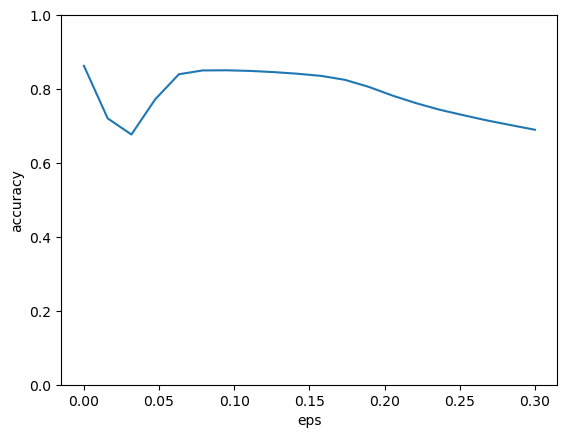

In [31]:
curve(accuracy)

##### Quantization:

In [32]:
accuracy = []
metric = []
defender = QuantizationDefender(model)
for eps in tqdm(eps_space):
    attacker = FGSMAttacker(defender, eps=eps)
    accuracy.append(evaluate(defender, attacker))

Quantization training...


Epochs ...:   0%|          | 0/15 [00:00<?, ?it/s]

Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 1, Loss: 0.1106


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0852


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0763


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0701


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0659


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0623


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0600


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 8, Loss: 0.0578


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0558


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 10, Loss: 0.0543


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 11, Loss: 0.0526


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 12, Loss: 0.0512


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 13, Loss: 0.0499


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 14, Loss: 0.0484


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 15, Loss: 0.0477


  0%|          | 0/20 [00:00<?, ?it/s]

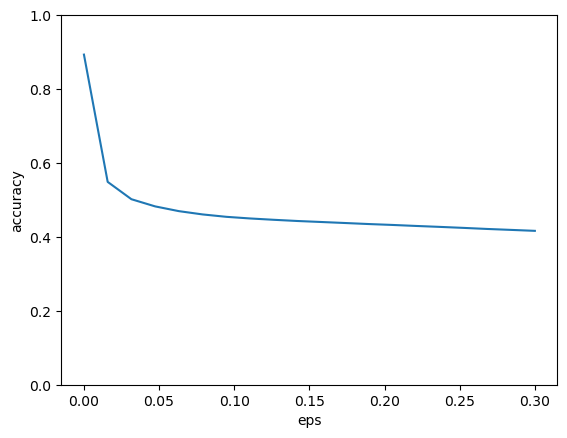

In [33]:
curve(accuracy)

##### Adversarial Training on Quantized Data:

In [34]:
accuracy = []
metric = []
defender = ATQDefender(model)
for eps in tqdm(eps_space):
    attacker = FGSMAttacker(defender, eps=eps)
    accuracy.append(evaluate(defender, attacker))

ATQ training...


Epochs ...:   0%|          | 0/15 [00:00<?, ?it/s]

Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 1, Loss: 0.2653


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 2, Loss: 0.1670


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 3, Loss: 0.1550


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 4, Loss: 0.1453


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 5, Loss: 0.1387


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 6, Loss: 0.1369


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 7, Loss: 0.1334


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 8, Loss: 0.1276


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 9, Loss: 0.1265


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 10, Loss: 0.1267


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 11, Loss: 0.1224


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 12, Loss: 0.1223


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 13, Loss: 0.1197


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 14, Loss: 0.1189


Steps ...:   0%|          | 0/8536 [00:00<?, ?it/s]

Epoch 15, Loss: 0.1155


  0%|          | 0/20 [00:00<?, ?it/s]

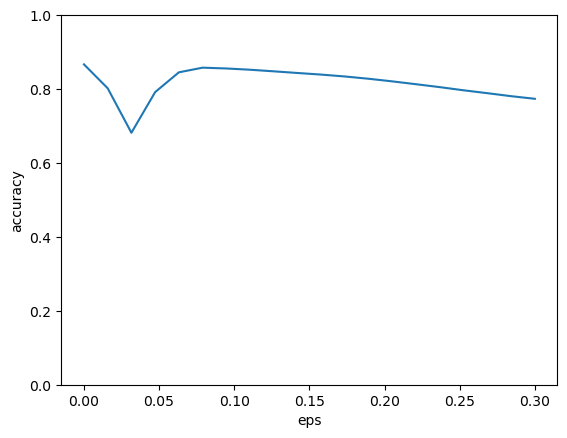

In [35]:
curve(accuracy)